# Imports

In [1]:
# Pytorch
import torch
from torch.nn import CrossEntropyLoss, Conv2d, Linear, ReLU, Sequential, Sigmoid, Tanh, Softmax, MSELoss, Dropout, LeakyReLU, ELU
from torch.optim import SGD, Adam
from torch.nn.functional import mse_loss

# helper
import numpy as np
from math import sqrt, pi as PI
import copy

# Visualization
import pandas as pd
from matplotlib import pyplot as plt

# Data generation

In [2]:
N_STEPS = 200
N_SIMULATIONS = 1000
MIN_X, MAX_X = [0, 20]
MIN_Y, MAX_Y = [0, 20]
N_WIFIS = 4
N_BLUETOOTHS = 2

In [3]:
def generate_random_simulation(min_x, max_x, min_y, max_y, n_steps):
    # generate starting position
    start_x = min_x + (max_x - min_x) * torch.rand(1)
    start_y = min_y + (max_y - min_y) * torch.rand(1)
    
    # generate random directions
    random_angles = torch.rand(N_STEPS) * 2 * PI
    random_dir_xs = torch.cos(random_angles)
    random_dir_ys = torch.sin(random_angles)
    random_dirs = torch.cat((random_dir_xs[..., None], random_dir_ys[..., None]), 1)
    
    # generate resulting positions
    positions = []
    GAMMA = 0.75 # momentum factor
    pos_x = start_x
    pos_y = start_y
    dir_prev_x, dir_prev_y = random_dirs[0]
    for dir_x, dir_y in random_dirs:
        # weighted average between the new and previous direction (to have some smoothness)
        newDir_x = (1 - GAMMA) * dir_x + GAMMA * dir_prev_x
        newDir_y = (1 - GAMMA) * dir_y + GAMMA * dir_prev_y
        dir_prev_x = newDir_x
        dir_prev_y = newDir_y

        # bound the obtained position
        pos_x = torch.clamp(pos_x + newDir_x, min_x, max_x)
        pos_y = torch.clamp(pos_y + newDir_y, min_y, max_y)

        positions.append([pos_x, pos_y])

    positions = torch.FloatTensor(positions)
    
    return positions

In [4]:
random_simulations = torch.stack([generate_random_simulation(MIN_X, MAX_X, MIN_Y, MAX_Y, N_STEPS) for i in range(N_SIMULATIONS)])

In [5]:
wifi_pos = torch.cat((
    MIN_X + (MAX_X - MIN_X) * torch.rand(N_SIMULATIONS, N_WIFIS, 1),
    MIN_Y + (MAX_Y - MIN_Y) * torch.rand(N_SIMULATIONS, N_WIFIS, 1)
), -1)

bluetooth_pos = torch.cat((
    MIN_X + (MAX_X - MIN_X) * torch.rand(N_SIMULATIONS, N_BLUETOOTHS, 1),
    MIN_Y + (MAX_Y - MIN_Y) * torch.rand(N_SIMULATIONS, N_BLUETOOTHS, 1)
), -1)

In [6]:
def plot_simulation(positions, wifi_pos, bluetooth_pos):
    plt.plot(*positions.T)
    for x, y in wifi_pos:
        plt.plot(x, y, '.', c='r', markersize=15)
        
    for x, y in bluetooth_pos:
        plt.plot(x, y, '.', c='lightblue', markersize=15)

    plt.plot(*positions[0], '*', c='green', markersize=15)
    plt.plot(*positions[-1], '*', c='orange', markersize=15);

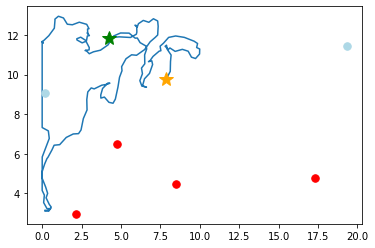

In [7]:
plot_simulation(random_simulations[0], wifi_pos[0], bluetooth_pos[0])

In [8]:
def noise(size, std):
    return torch.Tensor(size).normal_(std=std)

RSSI_T = 60
RSSI_N = 2
RSSI_STD = 1
def RSSI(dist):
    return RSSI_T - 10 * RSSI_N * torch.log10(dist) + noise(dist.size(), RSSI_STD)

RTT_A = 10
RTT_B = 10
RTT_STD = 4
def RTT(dist):
    return RTT_A * dist + RTT_B + noise(dist.size(), RTT_STD)

In [9]:
wifi_distances = (random_simulations[..., None, :] - wifi_pos[:, None, ...]).pow(2).sum(dim=3).sqrt()
wifi_RSSIs = RSSI(wifi_distances)
wifi_RTTs = RTT(wifi_distances)

bluetooth_distances = (random_simulations[..., None, :] - bluetooth_pos[:, None, ...]).pow(2).sum(dim=3).sqrt()
bluetooth_RSSIs = RSSI(bluetooth_distances)

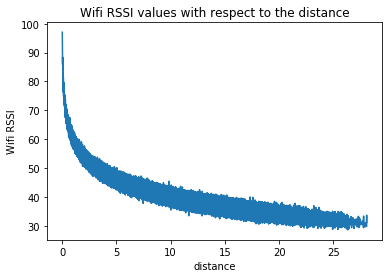

In [10]:
values, indices = wifi_distances.flatten().sort()
plt.plot(values, wifi_RSSIs.flatten()[indices])
plt.title('Wifi RSSI values with respect to the distance');
plt.xlabel('distance')
plt.ylabel('Wifi RSSI');

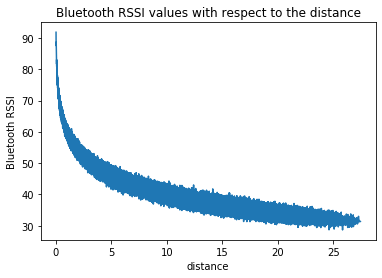

In [11]:
values, indices = bluetooth_distances.flatten().sort()
plt.plot(values, bluetooth_RSSIs.flatten()[indices])
plt.title('Bluetooth RSSI values with respect to the distance');
plt.xlabel('distance')
plt.ylabel('Bluetooth RSSI');

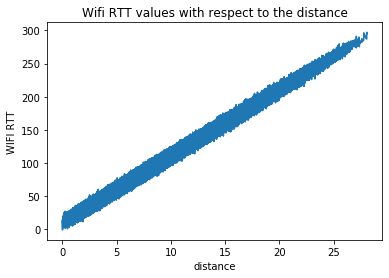

In [12]:
values, indices = wifi_distances.flatten().sort()
plt.plot(values, wifi_RTTs.flatten()[indices])
plt.title('Wifi RTT values with respect to the distance');
plt.xlabel('distance')
plt.ylabel('WIFI RTT');

In [13]:
data = torch.cat((
    wifi_pos.view(N_SIMULATIONS, 1, 2 * N_WIFIS).repeat(1, N_STEPS, 1),
    wifi_RSSIs,
    wifi_RTTs,
    bluetooth_pos.view(N_SIMULATIONS, 1, 2 * N_BLUETOOTHS).repeat(1, N_STEPS, 1),
    bluetooth_RSSIs,
    random_simulations
), -1)

In [14]:
n_attr = 4 * N_WIFIS + 3 * N_BLUETOOTHS
n_out = 2
assert n_attr + n_out == data.size(-1)

In [15]:
data_input = data.narrow(2, 0, n_attr)
data_target = data.narrow(2, n_attr, n_out)

# Train and evaluation functions

In [16]:
BATCH_SIZE = 100
N_EPOCHS = 100

criterion = MSELoss()
optimizer_algo = Adam

In [17]:
def random_split(data, ratio):
    split = int(ratio * data.size(0))
    
    random_indices = torch.randperm(data.size(0))
    indices_a = random_indices[:split]
    indices_b = random_indices[split:]
    
    data_a = data[indices_a]
    data_b = data[indices_b]
    
    return data_a, data_b

def cross_validation_split(data, k):
    for i in range(k):
        train_data = torch.cat((data[:i * data.size(0) // k], data[(i + 1) * data.size(0) // k:]), dim=0)
        test_data = data[i * data.size(0) // k: (i + 1) * data.size(0) // k]
        yield (train_data, test_data)

In [18]:
def weight_reset(m):
    """Reinitilize every linear and convolutional layer parameters in the model"""
    if isinstance(m, Conv2d) or isinstance(m, Linear):
        m.reset_parameters()

def copy_model(model):
    return copy.deepcopy(model)

In [19]:
def train_model(model, train_input, train_target, nb_epochs=N_EPOCHS, batch_size=BATCH_SIZE, test_input=None, test_target=None):
    """Train a model"""
    
    optimizer = optimizer_algo(model.parameters())
    train_losses = []
    if test_input is not None and test_target is not None:
        test_losses = []

    for _ in range(nb_epochs):
        batch_losses = []
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            loss = criterion(output, train_target.narrow(0, b, batch_size))
            batch_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(torch.Tensor(batch_losses).mean().item())
        
        if test_input is not None and test_target is not None:
            test_output = model(test_input)
            test_loss = criterion(test_output, test_target)
            test_losses.append(test_loss.item())
    if test_input is not None and test_target is not None:
        return train_losses, test_losses
    else:
        return train_losses

In [20]:
def compute_loss(model, data_input, data_target):
    """Compute the loss of the output of the model with respect to the target"""
    output = model(data_input)
    loss = loss_function(output, data_target)
    
    return loss

In [21]:
def train_and_evaluate(model, train_input, train_target, test_input, test_target, nb_trials=10):
    losses = torch.zeros(nb_trials)
    
    for i in range(nb_trials):
        model.apply(weight_reset)
        
        # train
        train_model(model, train_input, train_target, N_EPOCHS, BATCH_SIZE)

        # evaluate
        loss = compute_loss(model, test_input, test_target, criterion)
        losses[i] = loss
    
    loss_mean = losses.mean().item()
    std = losses.std().item()
    ci_95 = 1.96 * std / sqrt(nb_trials)
    
    return {'losses': losses,
            'mean': loss_mean,
            'std': std,
            'confidence_interval_95': ci_95
           }

In [22]:
def cross_val(model, data_input, data_target, k, flatten=False):
    losses = []
    
    for train_data, test_data in cross_validation_split(data, k):
        model.apply(weight_reset)
        
        # train
        train_model(model, train_input, train_target, N_EPOCHS)
        
        # evaluate
        loss = compute_loss(model, test_input, test_target, criterion)
        losses[i] = loss
    
    mean = losses.mean().item()
    std = losses.std().item()
    ci_95 = 1.96 * std / sqrt(k)
    
    return {'losses': losses,
            'mean': mean,
            'std': std,
            'confidence_interval_95': ci_95
           }

In [23]:
RATIO = 0.8
split = int(RATIO * data.size(0))
random_indices = torch.randperm(data.size(0))
train_indices = random_indices[:split]
test_indices = random_indices[split:]

train_input = data_input[train_indices]
train_target = data_target[train_indices]
test_input = data_input[test_indices]
test_target = data_target[test_indices]

In [24]:
def plot_loss_evolution(train_losses, test_losses):
    plt.plot(train_losses, c='blue')
    plt.plot(test_losses, c='orange')
    plt.legend(['train loss', 'test loss'])
    plt.ylim(0, 50)
    plt.grid();

CPU times: user 1min 4s, sys: 2.95 s, total: 1min 7s
Wall time: 47.8 s


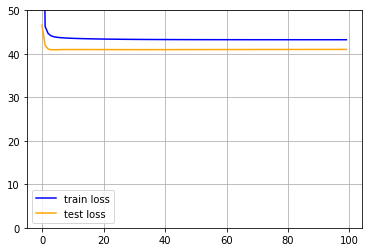

In [25]:
%%time

model = Sequential(
    Linear(n_attr, 2)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

CPU times: user 1min 42s, sys: 3.58 s, total: 1min 46s
Wall time: 1min 26s


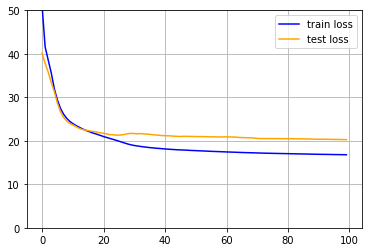

In [26]:
%%time

model = Sequential(
    Linear(n_attr, 16), ReLU(),
    Linear(16, 2)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

CPU times: user 2min 40s, sys: 55.8 s, total: 3min 36s
Wall time: 1min 38s


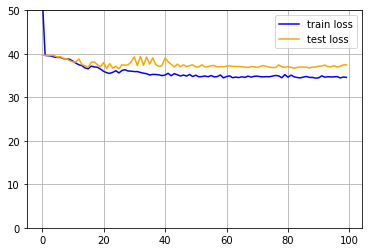

In [27]:
%%time

model = Sequential(
    Linear(n_attr, 16), Tanh(),
    Linear(16, 2)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

CPU times: user 1min 35s, sys: 11.2 s, total: 1min 46s
Wall time: 1min 26s


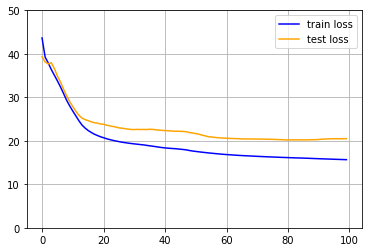

In [28]:
%%time

model = Sequential(
    Linear(n_attr, 16), LeakyReLU(),
    Linear(16, 2)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

CPU times: user 1min 41s, sys: 11.4 s, total: 1min 52s
Wall time: 1min 33s


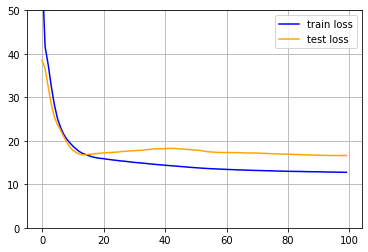

In [29]:
%%time

model = Sequential(
    Linear(n_attr, 32), ReLU(),
    Linear(32, 2)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

CPU times: user 5min 31s, sys: 2min 30s, total: 8min 2s
Wall time: 2min 44s


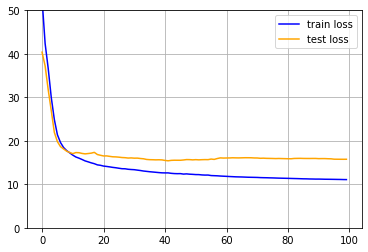

In [30]:
%%time

model = Sequential(
    Linear(n_attr, 64), ReLU(),
    Linear(64, 2)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

CPU times: user 2min 42s, sys: 12 s, total: 2min 54s
Wall time: 2min 34s


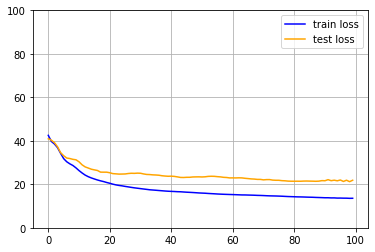

In [42]:
%%time

model = Sequential(
    Linear(n_attr, 16), ReLU(),
    Linear(16, 16), ReLU(),
    Linear(16, 16), ReLU(),
    Linear(16, n_out)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

CPU times: user 7min 29s, sys: 3min 20s, total: 10min 50s
Wall time: 3min 41s


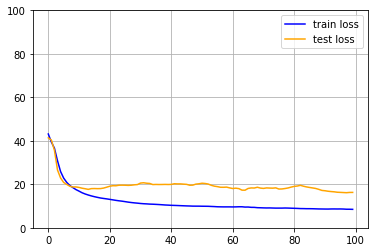

In [43]:
%%time

model = Sequential(
    Linear(n_attr, 32), ReLU(),
    Linear(32, 32), ReLU(),
    Linear(32, n_out)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

CPU times: user 10min 20s, sys: 4min 32s, total: 14min 53s
Wall time: 5min 1s


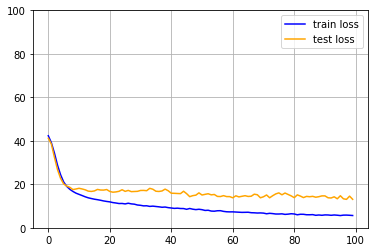

In [54]:
%%time

model = Sequential(
    Linear(n_attr, 64), ReLU(),
    Linear(64, 32), ReLU(),
    Linear(32, 16), ReLU(),
    Linear(16, n_out)
)

train_losses, test_losses = train_model(model, train_input.view(-1, n_attr), train_target.view(-1, n_out),
                                        test_input=test_input.view(-1, n_attr), test_target=test_target.view(-1, n_out))

plot_loss_evolution(train_losses, test_losses)

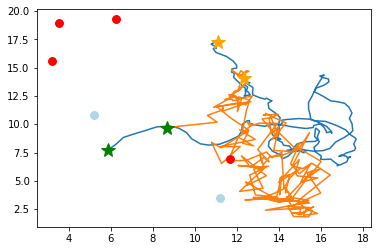

In [60]:
sim_idx = test_indices[0]
plot_simulation(random_simulations[sim_idx], wifi_pos[sim_idx], bluetooth_pos[sim_idx])
plot_simulation(model(data[sim_idx].narrow(1, 0, n_attr)).detach(), wifi_pos[sim_idx], bluetooth_pos[sim_idx])